## Lab 3 - RecSys
---

#### Miquel Monge Dalmau, NIU: 1565230
#### Mateo Sesma Urbano, NIU: 1568353

---

### PySpark Initialization

Primero de todo, debemos inicializar PySpark, de la misma forma que hemos utilizado en sesiones anteriores. Además, aprovechamos para importar todas las librerías que utilizamos a lo largo de la práctica.

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

In [2]:
if not ("spark" in vars() or "spark" in globals()):
    from pyspark.sql import SparkSession
    spark = SparkSession.builder.appName("covtype-training").master("local").getOrCreate()
else:
    print("all done")
    
import warnings
warnings.filterwarnings("ignore")

all done


### Load / Clean data

Una vez inicializado el contexto de PySpark, vamos a cargar los datos. En este caso, tenemos un archivo en format .csv que dispone de *header*. A la hora de cargar los datos, dejamos que Spark infiera en el schema de forma automática con *inferSchema a True*

In [3]:
data = spark.read.option("header", True).csv("covtype.csv", inferSchema = True)

Una vez hemos cargado el archivo en memoria, podemos empezar con la exploración. En esta, veremos características de los datos. Para empezar, es bueno saber el número de columnas y filas que tiene nuestro csv.

In [4]:
total_rows = data.count()
print(f"No.rows: {total_rows}")
print(f"No.columns: {len(data.columns)}")


No.rows: 577231
No.columns: 55


Ahora vamos a ver el schema de nuestros datos, recordamos que de la forma en que hemos leído los datos, Spark ha detectado el *schema* de forma automática.

In [5]:
data.printSchema()

root
 |-- Elevation: integer (nullable = true)
 |-- Aspect: integer (nullable = true)
 |-- Slope: integer (nullable = true)
 |-- Horizontal_Distance_To_Hydrology: integer (nullable = true)
 |-- Vertical_Distance_To_Hydrology: integer (nullable = true)
 |-- Horizontal_Distance_To_Roadways: integer (nullable = true)
 |-- Hillshade_9am: integer (nullable = true)
 |-- Hillshade_Noon: integer (nullable = true)
 |-- Hillshade_3pm: integer (nullable = true)
 |-- Horizontal_Distance_To_Fire_Points: integer (nullable = true)
 |-- Wilderness_Area1: integer (nullable = true)
 |-- Wilderness_Area2: integer (nullable = true)
 |-- Wilderness_Area3: integer (nullable = true)
 |-- Wilderness_Area4: integer (nullable = true)
 |-- Soil_Type1: integer (nullable = true)
 |-- Soil_Type2: integer (nullable = true)
 |-- Soil_Type3: integer (nullable = true)
 |-- Soil_Type4: integer (nullable = true)
 |-- Soil_Type5: integer (nullable = true)
 |-- Soil_Type6: integer (nullable = true)
 |-- Soil_Type7: integer

Mirando la información de la columna, está claro que algunas características son numéricas. “Elevation” es una elevación en metros; "Slope” se mide en grados. Sin embargo, "Wilderness_Area" es algo diferente, porque se dice que abarca cuatro columnas, cada una de las cuales es un 0 o 1. En realidad, "Wilderness_Area" es un valor categórico, no numérico.

Estas cuatro columnas son en realidad una codificación one-hot o 1-of-n. Cuando esta forma de codificación se realiza en una característica categórica, una característica categórica que toma N valores distintos se convierte en N características numéricas, cada una de las cuales toma el valor 0 o 1. Exactamente uno de los N valores tiene el valor 1, y los otros son 0. 

También vemos que la variable target "Cover_Type" es un valor categorico *encoded* con valores de 1 al 7.

Primeramente, separaremos los datos en train i test para así poder más tarde poder predecir un label del conjunto de datos. Limpiaremos sobre el conjunto de entrenamiento.

In [6]:
seed = 6
(train, test) = data.randomSplit([0.9 ,0.1], seed = seed)
train.cache()
test.cache()

DataFrame[Elevation: int, Aspect: int, Slope: int, Horizontal_Distance_To_Hydrology: int, Vertical_Distance_To_Hydrology: int, Horizontal_Distance_To_Roadways: int, Hillshade_9am: int, Hillshade_Noon: int, Hillshade_3pm: int, Horizontal_Distance_To_Fire_Points: int, Wilderness_Area1: int, Wilderness_Area2: int, Wilderness_Area3: int, Wilderness_Area4: int, Soil_Type1: int, Soil_Type2: int, Soil_Type3: int, Soil_Type4: int, Soil_Type5: int, Soil_Type6: int, Soil_Type7: int, Soil_Type8: int, Soil_Type9: int, Soil_Type10: int, Soil_Type11: int, Soil_Type12: int, Soil_Type13: int, Soil_Type14: int, Soil_Type15: int, Soil_Type16: int, Soil_Type17: int, Soil_Type18: int, Soil_Type19: int, Soil_Type20: int, Soil_Type21: int, Soil_Type22: int, Soil_Type23: int, Soil_Type24: int, Soil_Type25: int, Soil_Type26: int, Soil_Type27: int, Soil_Type28: int, Soil_Type29: int, Soil_Type30: int, Soil_Type31: int, Soil_Type32: int, Soil_Type33: int, Soil_Type34: int, Soil_Type35: int, Soil_Type36: int, So

En el conjunto de test eliminaremos el label "Cover_Type" para así poder predecirlo posteriormente en la sección de Model Training.

In [8]:
test = test.drop("Cover_Type") # variable to predict
data.select("Cover_Type").describe().show()

+-------+------------------+
|summary|        Cover_Type|
+-------+------------------+
|  count|            577231|
|   mean|2.0387089397485583|
| stddev|1.3826702738435552|
|    min|                 1|
|    max|                 7|
+-------+------------------+



Para poder limpiar los datos, primero debemos saber si en nuestro archivo existen valores NaN. El primer paso para la limpieza del dataset suele ser eliminar estos valores o substituirlos (por la media, valor por defecto, etc). Para poder hacer esta limpieza de forma senzilla, trabajaremos con PandasDataframes.

In [7]:
train_pd = train.toPandas()
test_pd = test.toPandas()
print(train_pd.shape)

(519715, 55)


In [9]:
print(f"Existen valores nulos en el CSV: {train_pd.isnull().values.any()}")

Existen valores nulos en el CSV: False


En esta primera exploración para la limpieza del dataset, vemos que no existen valores nulos en este. Podemos asegurarnos de otra manera:

In [10]:
print(f"Total de atributos con valor NaN: {train_pd.isnull().sum().sum()}")

Total de atributos con valor NaN: 0


Ahora utilizaremos ScatterPlots, ya que son una excelente fuente de información a la hora de limpiar los datos. Probaremos con algunas variables.

<AxesSubplot:xlabel='Hillshade_3pm', ylabel='Hillshade_Noon'>

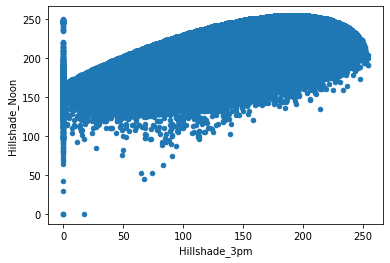

In [11]:
train_pd.plot.scatter(x="Hillshade_3pm", y = "Hillshade_Noon")

Vemos que tenemos algunos outliers. Todo esto lo corregiremos más tarde. También podemos visualizar las distribuciones que siguen las variables (histogramas, boxplot), que nos pueden ayudar a la hora de limpiar los datos.

A continuación podremos observar unas cuantas observaciones de nuestro dataset para así hacernos una idea previa de este.

In [12]:
train_pd.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1863,37,17,120,18,90,217,202,115,769,...,0,0,0,0,0,0,0,0,0,6
1,1874,18,14,0,0,90,208,209,135,793,...,0,0,0,0,0,0,0,0,0,6
2,1879,28,19,30,12,95,209,196,117,778,...,0,0,0,0,0,0,0,0,0,6
3,1896,337,12,30,6,175,195,224,168,732,...,0,0,0,0,0,0,0,0,0,6
4,1898,34,23,175,56,134,210,184,99,765,...,0,0,0,0,0,0,0,0,0,6


Nuestra variable target es "Cover_Type", por lo tanto, es interesante ver su distribución. Primero la veremos en forma númerica y luego la podremos gráficar.

En el siguiente código/gráfico podremos observar la distribución de los valores de dentro de nuestro target "Cover_Type".

In [13]:
print(train_pd["Cover_Type"].value_counts())

2    254741
1    190123
3     31787
7     17958
6     15086
5      8042
4      1978
Name: Cover_Type, dtype: int64


Ahora vamos a graficarla. Vemos que la mayoria de valores estan entre el 1 y el 2.

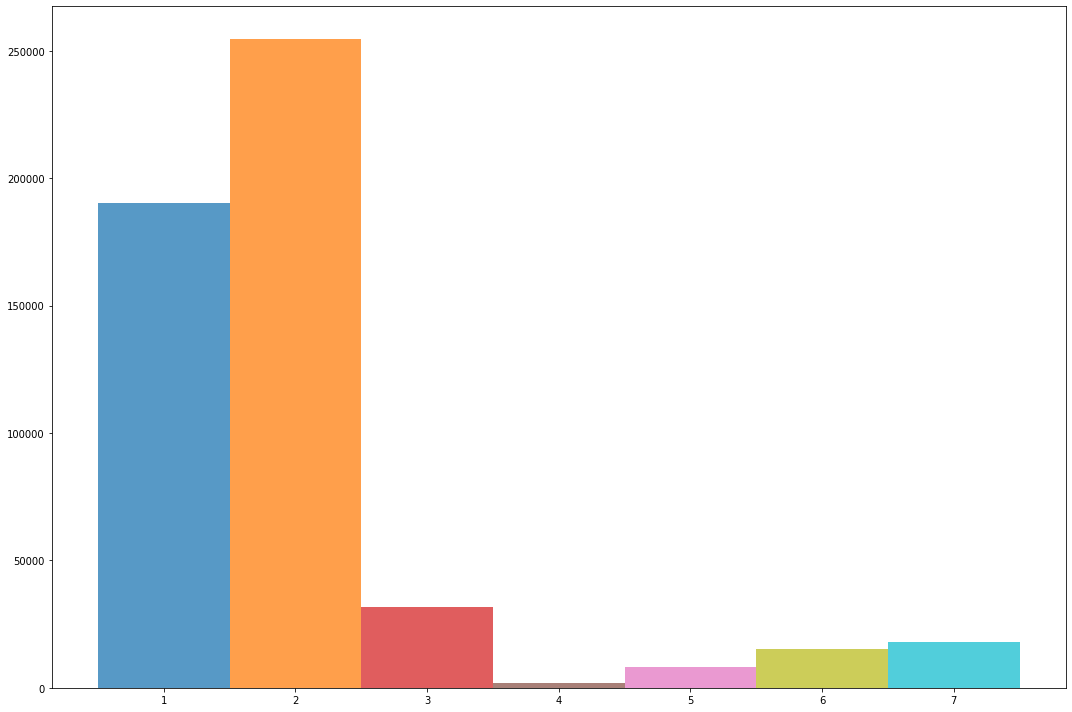

In [14]:
plt.figure(figsize=(15,10))
color = iter(plt.cm.tab10(np.linspace(0, 1, 7)))

for index in range(1,8):
    plt.hist(train_pd.loc[train_pd["Cover_Type"] == index, "Cover_Type"], label = "Type " + str(index), bins = np.arange(1,9)-0.5, alpha = .75, color = next(color))
    
plt.tight_layout()
plt.show()

Observamos que obtenemos muchos valores asignados al label 2 y 1. Despues de mayor a menor 3, 7, 6, 5 y finalmente 4 donde obtenemos muy pocos en comparación con el resto.

Acabamos de comprobar que en todo el dataset de train no hay ningun valor nulo. Por lo tanto no se ha de hacer ninguna limpieza en este sentido en este. Los outliers se trataran más adelante.

---
### EDA

Empezaremos con la exploracion de datos viendo el tipo de estos. Más adelante, aportaremos graficas que nos ayudaran a sacar información sobre los datos.

In [15]:
print('Columns overview')
pd.DataFrame(train_pd.dtypes, columns = ['Data type'])

Columns overview


,Data type
Elevation,int32
Aspect,int32
Slope,int32
Horizontal_Distance_To_Hydrology,int32
Vertical_Distance_To_Hydrology,int32
Horizontal_Distance_To_Roadways,int32
Hillshade_9am,int32
Hillshade_Noon,int32
Hillshade_3pm,int32
Horizontal_Distance_To_Fire_Points,int32


Vemos que todos los datos son numericos (int32).

In [16]:
wild_cols = [f"Wilderness_Area{i}" for i in range(1,5)]
print("Número total de 1 en Wilderness_AreaX", train_pd[wild_cols].sum().sum())

Número total de 1 en Wilderness_AreaX 519715


In [17]:
soil_cols = [f"Soil_Type{i}" for i in range(1,41)]
print("Número total de 1 en Soil_TypeX", train_pd[soil_cols].sum().sum())

Número total de 1 en Soil_TypeX 519715


Vamos a separar aquellas columnas **continuas** de aquellas **discretas**. Luego vamos a utilizar el método *describe* para describir diferentes medidas estadísticas sobre estas columnas.

In [18]:
all_cols = list(train_pd.columns)
label_cols = ["Cover_Type"]

discrete_cols= wild_cols + soil_cols + label_cols
continous_cols = [x for x in all_cols if x not in discrete_cols]

In [19]:
train_pd[continous_cols].describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
count,519715.000000,519715.000000,519715.000000,519715.000000,519715.000000,519715.000000,519715.000000,519715.000000,519715.000000,519715.000000
mean,2960.758847,155.616340,14.087829,269.686732,46.400533,2353.702437,212.140858,223.335901,142.567082,1983.360122
std,278.237836,111.940642,7.481346,212.437843,58.264399,1559.489423,26.753102,19.748484,38.214587,1325.576759
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2811.000000,58.000000,9.000000,108.000000,7.000000,1107.000000,198.000000,213.000000,119.000000,1025.000000
50%,2997.000000,127.000000,13.000000,218.000000,30.000000,2002.000000,218.000000,226.000000,143.000000,1712.000000
75%,3164.000000,261.000000,18.000000,384.000000,69.000000,3331.000000,231.000000,237.000000,168.000000,2552.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000


In [20]:
train_pd[discrete_cols].describe()

,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,519715.000000,519715.000000,519715.000000,519715.000000,519715.000000,519715.000000,519715.000000,519715.000000,519715.000000,519715.000000,...,519715.000000,519715.000000,519715.000000,519715.000000,519715.000000,519715.000000,519715.000000,519715.000000,519715.000000,519715.000000
mean,0.450101,0.051703,0.436135,0.062061,0.005109,0.012795,0.007906,0.021071,0.002678,0.011154,...,0.090806,0.077885,0.002830,0.003231,0.000210,0.000491,0.026734,0.023653,0.014958,2.038252
std,0.497504,0.221428,0.495905,0.241266,0.071292,0.112391,0.088565,0.143622,0.051684,0.105023,...,0.287333,0.267991,0.053126,0.056747,0.014481,0.022145,0.161305,0.151967,0.121386,1.381409
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


A continuación observaremos las correlaciones entre "Cover_Type" y todos los demás atributos del dataset. Elegimos esta variable ya que es la variable target de la practica.

In [21]:
correlations = train_pd.corr()["Cover_Type"]
print(correlations.sort_values())

Elevation                            -0.268540
Wilderness_Area1                     -0.201561
Horizontal_Distance_To_Roadways      -0.151131
Soil_Type22                          -0.141142
Soil_Type23                          -0.133935
Soil_Type29                          -0.122907
Horizontal_Distance_To_Fire_Points   -0.106680
Hillshade_Noon                       -0.093789
Soil_Type32                          -0.074092
Soil_Type24                          -0.068050
Soil_Type31                          -0.065319
Soil_Type33                          -0.061119
Wilderness_Area2                     -0.048190
Hillshade_3pm                        -0.046451
Soil_Type19                          -0.036634
Hillshade_9am                        -0.035476
Soil_Type20                          -0.028142
Soil_Type21                          -0.024902
Soil_Type12                          -0.021732
Horizontal_Distance_To_Hydrology     -0.018857
Soil_Type27                          -0.013960
Soil_Type30  

Podemos graficar un mapa de calor que nos ayude a interpretar la correlación entre las variables.

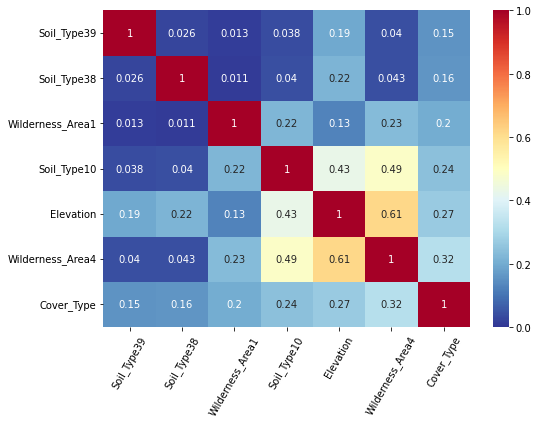

In [22]:
correlations_columns= ["Soil_Type39", "Soil_Type38", "Wilderness_Area1", "Soil_Type10", "Elevation", "Wilderness_Area4", "Cover_Type"]
correlations_df = train_pd[correlations_columns]

plt.figure(figsize= (8,6))
sns.heatmap(abs(correlations_df.corr()), cmap= plt.cm.RdYlBu_r, vmin=0, vmax= 1, annot=True)

plt.xticks(rotation= 60)

plt.tight_layout()
plt.show()

Siguiendo con el análisi, podemos averiguar los quartiles de nuestra variable target.

In [23]:
quantile = train.approxQuantile(['Cover_Type'], [0.25, 0.5, 0.75], 0)
quantile_25 = quantile[0][0]
quantile_50 = quantile[0][1]
quantile_75 = quantile[0][2]
print('quantile_25: '+str(quantile_25))
print('quantile_50: '+str(quantile_50))
print('quantile_75: '+str(quantile_75))

quantile_25: 1.0
quantile_50: 2.0
quantile_75: 2.0


#### Remove Outliers

Vamos a observar los datos de la columna Elevation respecto nuestro target 'Cover_Type'. Observando el gráfico haremos un filtro por encima de 3500 y por abajo de 2400.


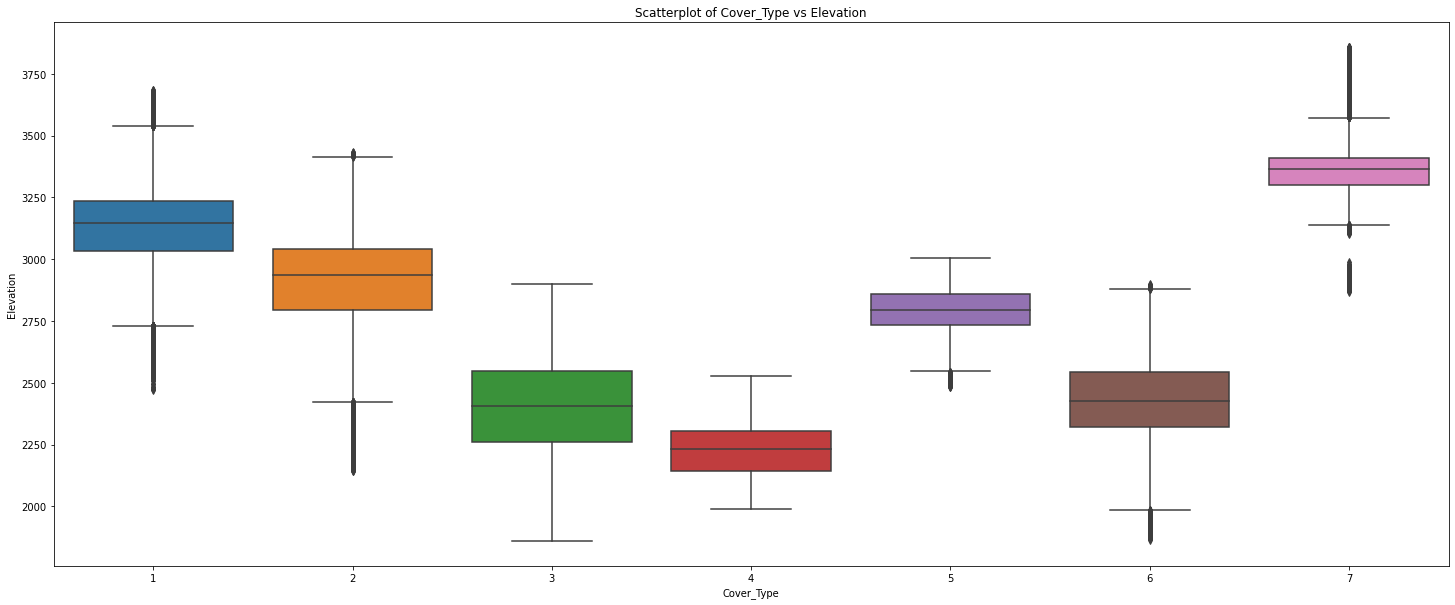

El resultado sería el siguiente: 


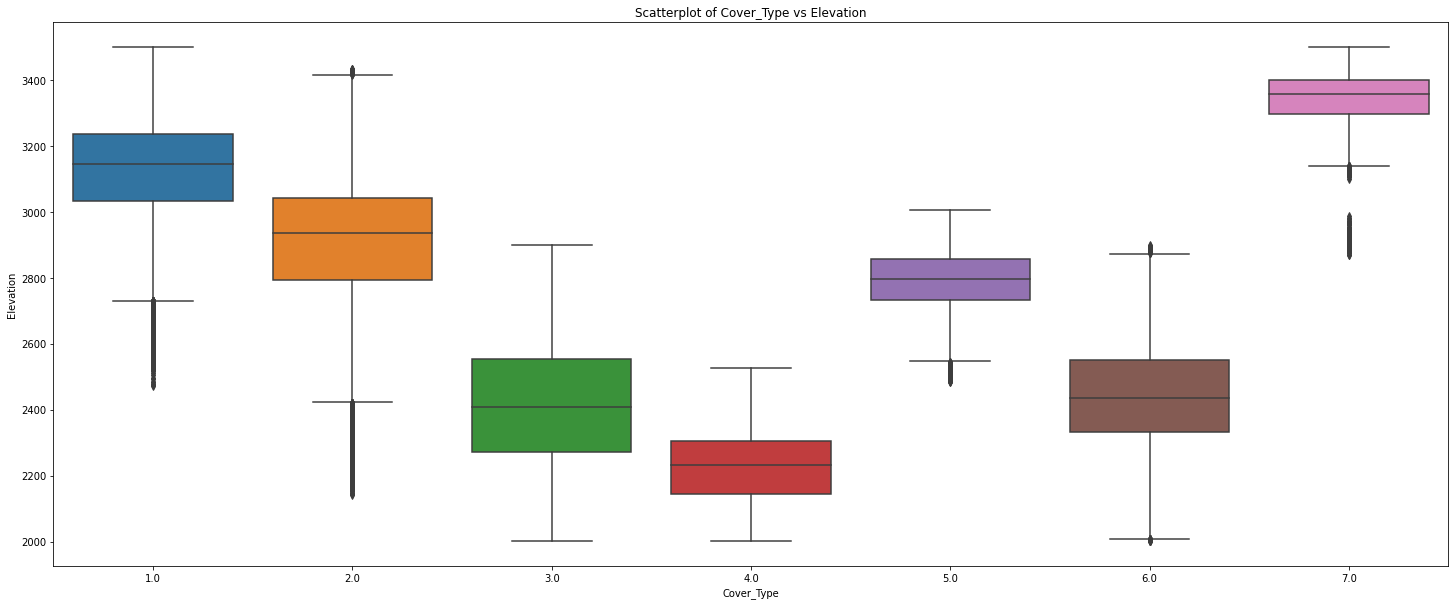

 ---------------------------------------------------- 


In [24]:
plt.figure(1, figsize=(25,10))
sns.boxplot(data=train_pd, x="Cover_Type", y="Elevation")
plt.title("Scatterplot of Cover_Type vs Elevation")
plt.show()

train_pd = train_pd.where(train_pd.Elevation < 3500)
train_pd = train_pd.where(train_pd.Elevation > 2000)

print("El resultado sería el siguiente: ")
plt.figure(1, figsize=(25,10))
sns.boxplot(data=train_pd, x="Cover_Type", y="Elevation")
plt.title(f"Scatterplot of Cover_Type vs Elevation")
plt.show()

print(" ---------------------------------------------------- ")


Vamos a observar los datos de la columna Slope respecto nuestro target 'Cover_Type'. Observando el gráfico haremos un filtro por abajo de 40.

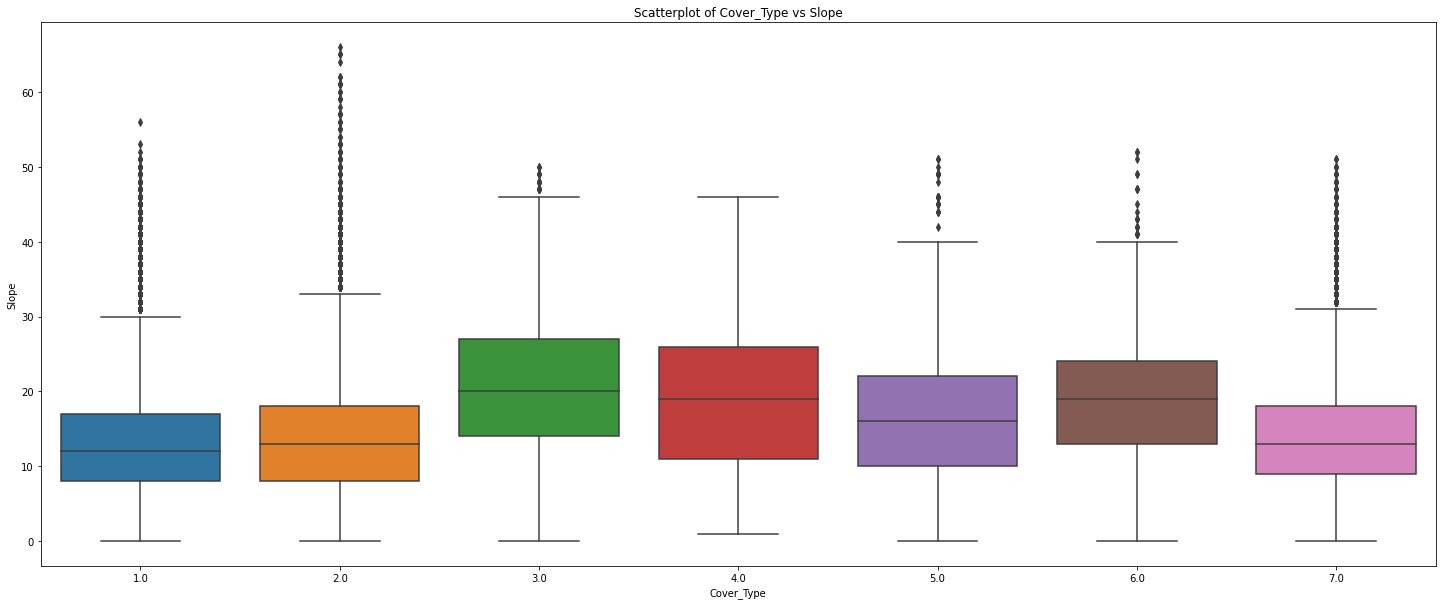

El resultado sería el siguiente: 


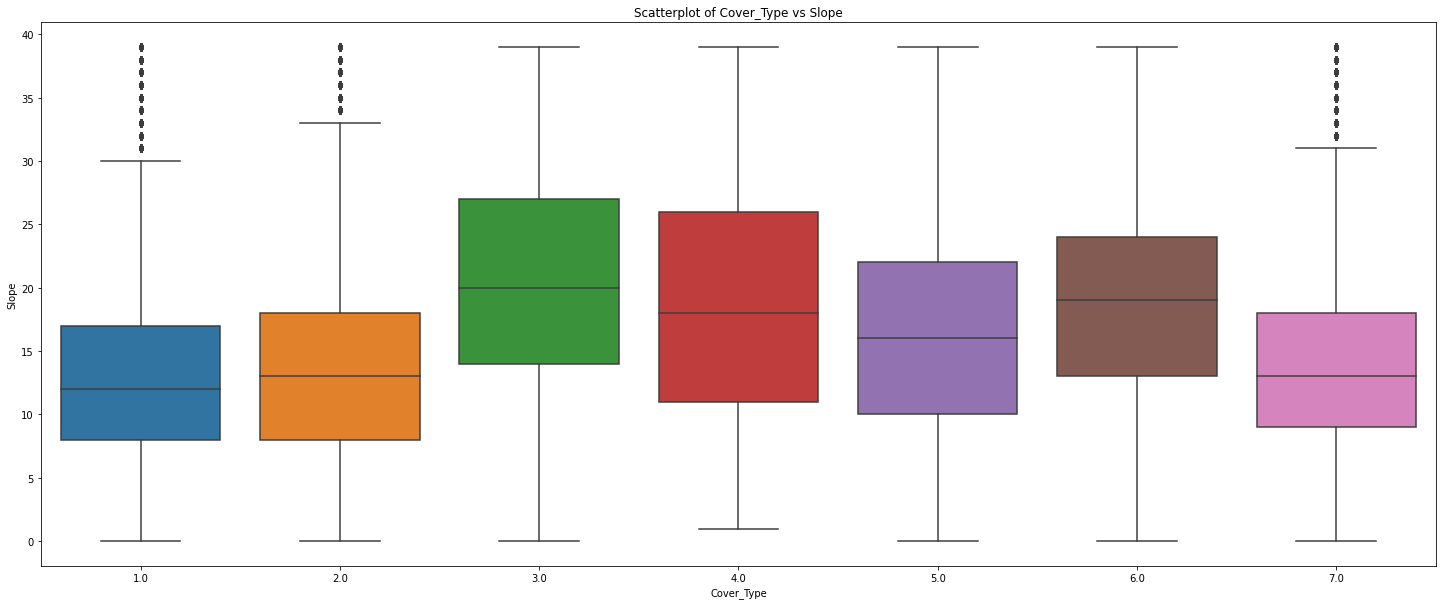

 ---------------------------------------------------- 


In [25]:
plt.figure(1, figsize=(25,10))
sns.boxplot(data=train_pd, x="Cover_Type", y='Slope')
plt.title(f"Scatterplot of Cover_Type vs Slope")
plt.show()

train_pd = train_pd.where(train_pd.Slope < 40)
   
print("El resultado sería el siguiente: ")
plt.figure(1, figsize=(25,10))
sns.boxplot(data=train_pd, x="Cover_Type", y="Slope")
plt.title(f"Scatterplot of Cover_Type vs Slope")
plt.show()
   
print(" ---------------------------------------------------- ")

Vamos a observar los datos de la columna Horizontal_Distance_To_Hydrology respecto nuestro target 'Cover_Type'. Observando el gráfico haremos un filtro por abajo de 1000.

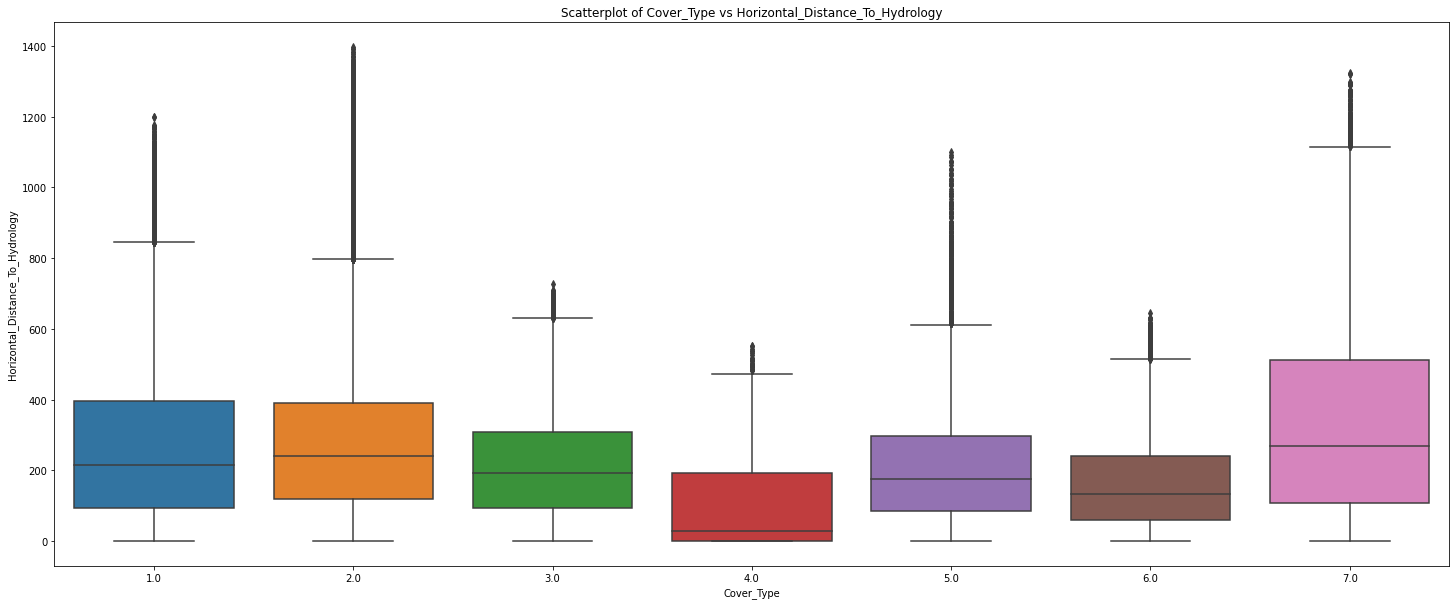

El resultado sería el siguiente: 


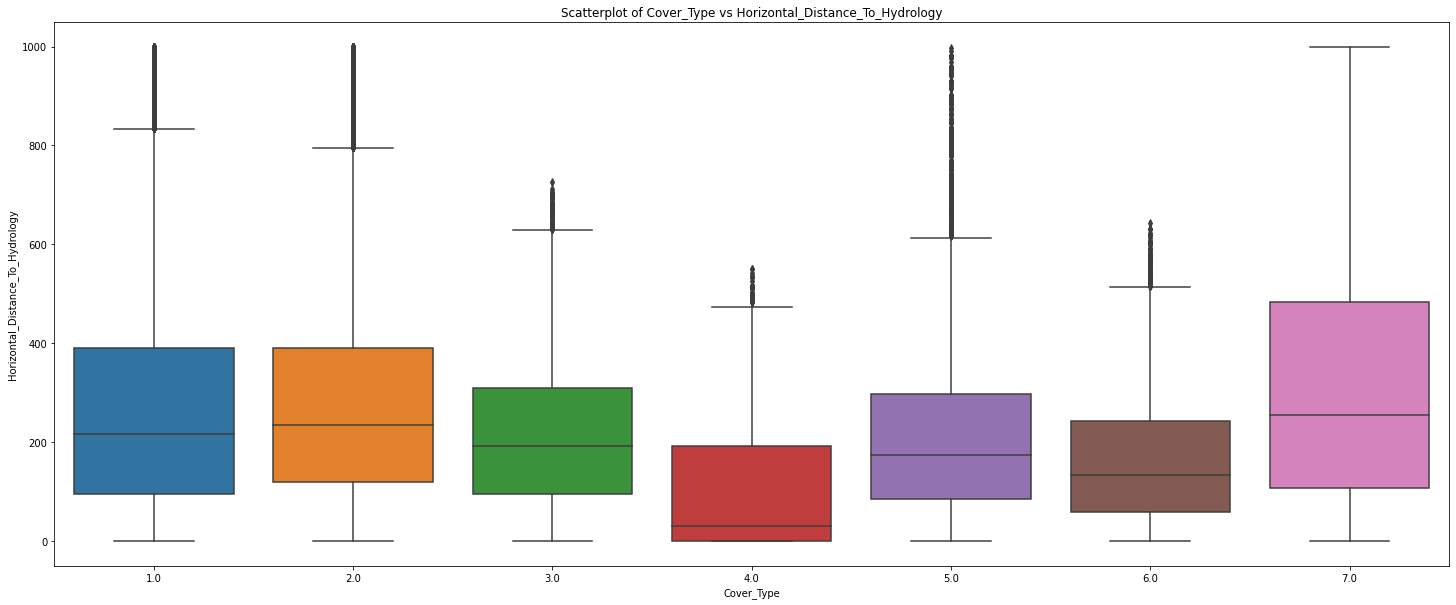

 ---------------------------------------------------- 


In [26]:
plt.figure(1, figsize=(25,10))
sns.boxplot(data=train_pd, x="Cover_Type", y='Horizontal_Distance_To_Hydrology')
plt.title(f"Scatterplot of Cover_Type vs Horizontal_Distance_To_Hydrology")
plt.show()


train_pd = train_pd.where(train_pd.Horizontal_Distance_To_Hydrology < 1000)
   
print("El resultado sería el siguiente: ")
plt.figure(1, figsize=(25,10))
sns.boxplot(data=train_pd, x="Cover_Type", y="Horizontal_Distance_To_Hydrology")
plt.title(f"Scatterplot of Cover_Type vs Horizontal_Distance_To_Hydrology")
plt.show()
   
print(" ---------------------------------------------------- ")


Vamos a observar los datos de la columna Vertical_Distance_To_Hydrology respecto nuestro target 'Cover_Type'. Observando el gráfico haremos un filtro por abajo de 200 y por encima de -100".
  

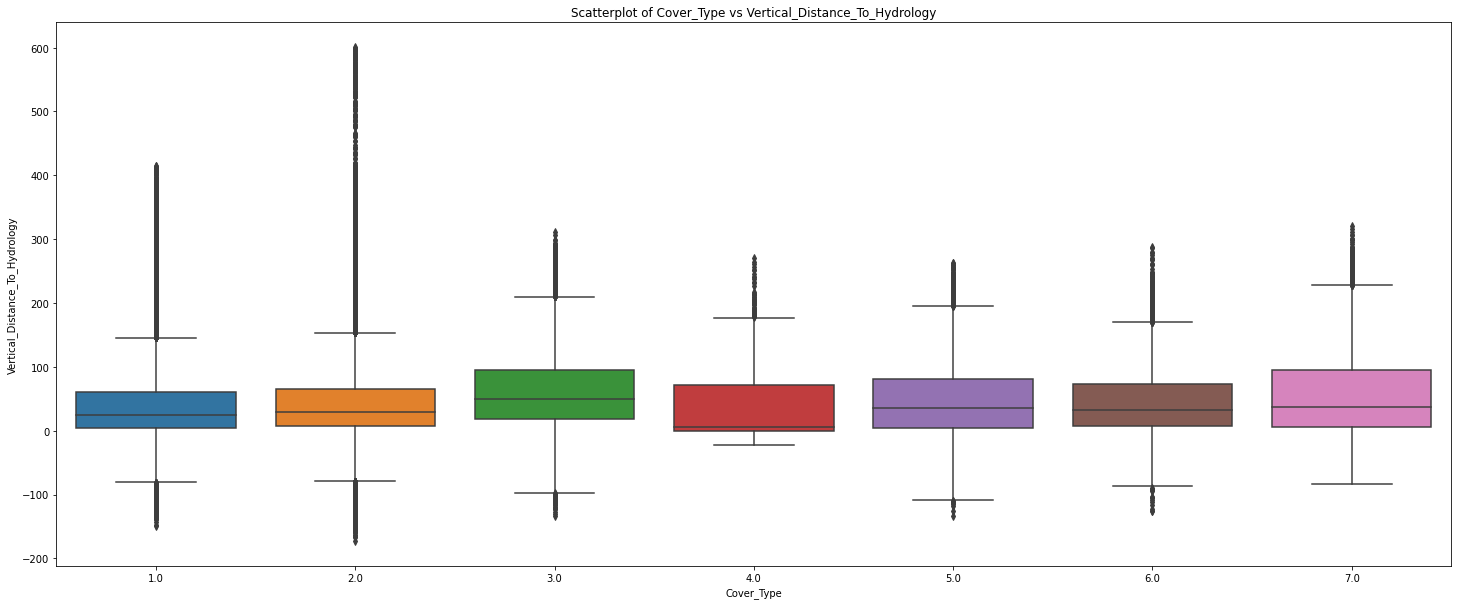

El resultado sería el siguiente: 


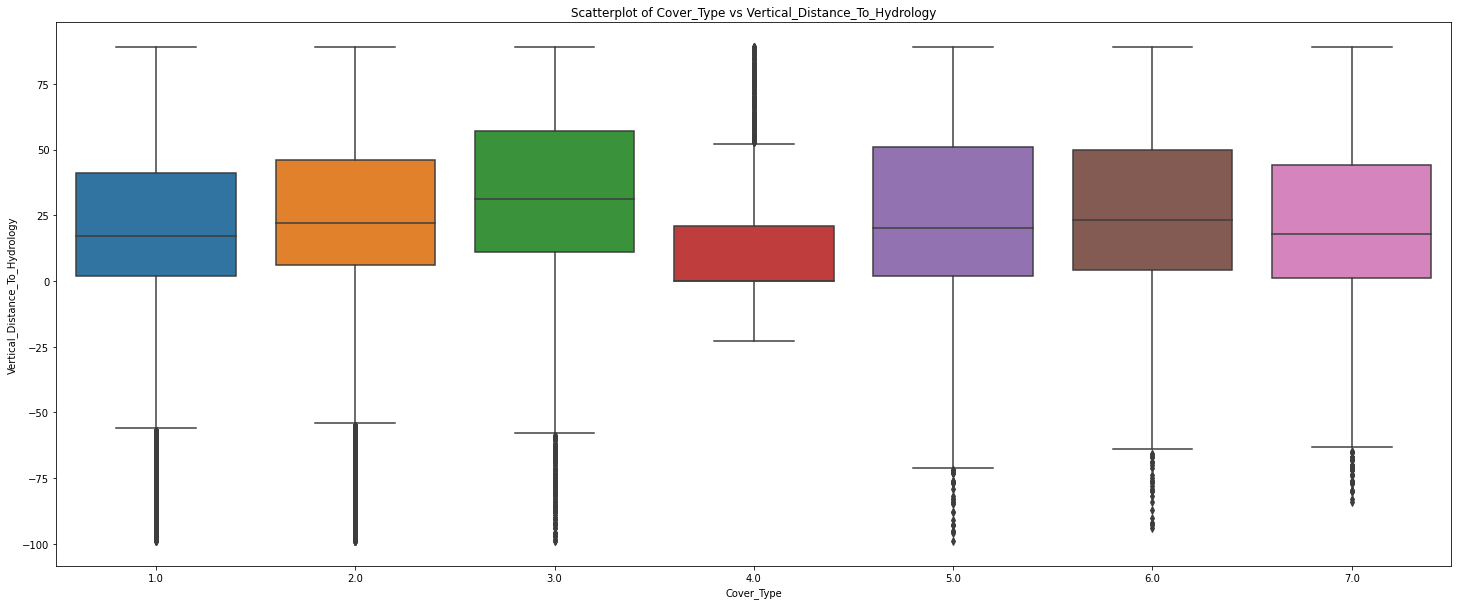

 ---------------------------------------------------- 


In [27]:
 plt.figure(1, figsize=(25,10))
sns.boxplot(data=train_pd, x="Cover_Type", y='Vertical_Distance_To_Hydrology')
plt.title(f"Scatterplot of Cover_Type vs Vertical_Distance_To_Hydrology")
plt.show()

train_pd = train_pd.where(train_pd.Vertical_Distance_To_Hydrology < 90)
train_pd = train_pd.where(train_pd.Vertical_Distance_To_Hydrology > -100)
   
print("El resultado sería el siguiente: ")
plt.figure(1, figsize=(25,10))
sns.boxplot(data=train_pd, x="Cover_Type", y="Vertical_Distance_To_Hydrology")
plt.title(f"Scatterplot of Cover_Type vs Vertical_Distance_To_Hydrology")
plt.show()
   
print(" ---------------------------------------------------- ")

Vamos a observar los datos de la columna Hillshade_9am respecto nuestro target 'Cover_Type'. Observando el gráfico haremos un filtro por abajo de 60.
  

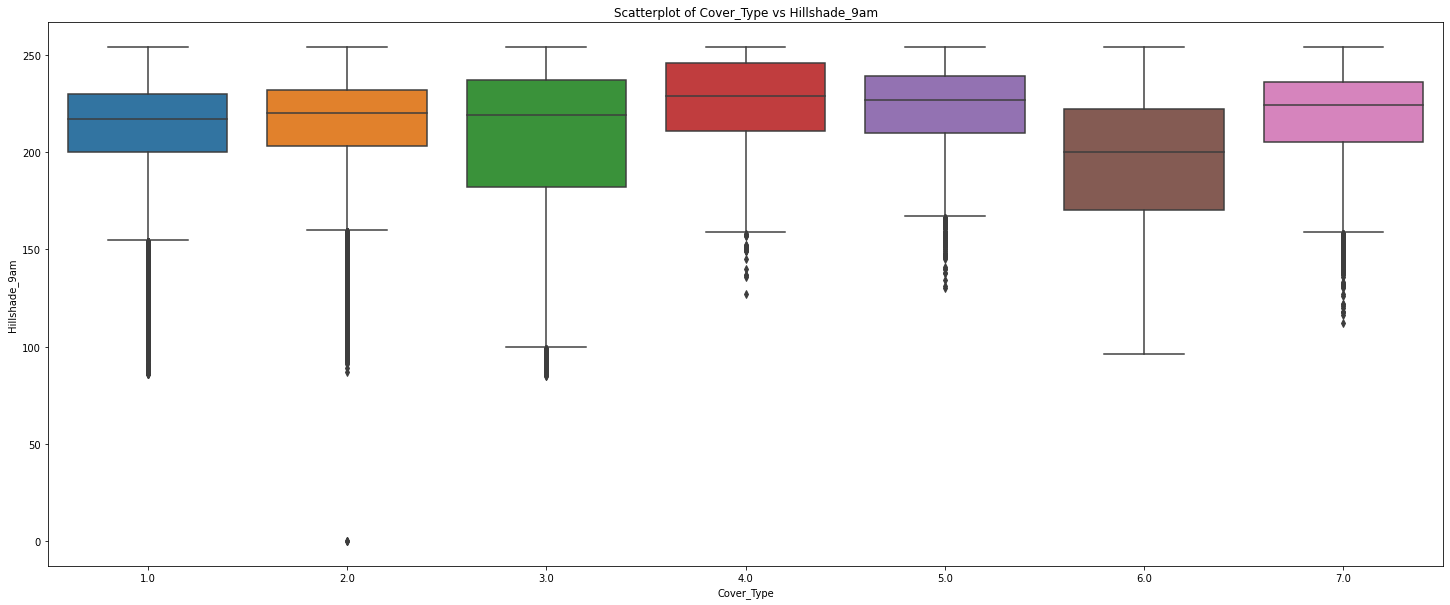

El resultado sería el siguiente: 


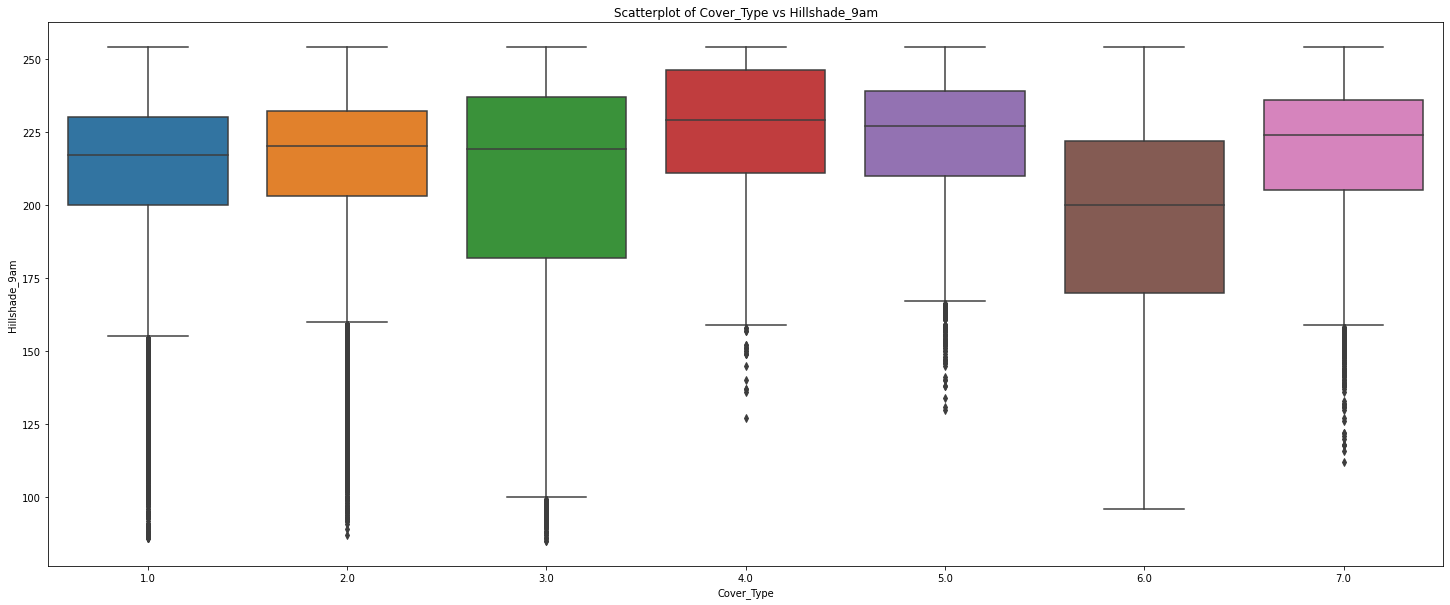

 ---------------------------------------------------- 


In [28]:
plt.figure(1, figsize=(25,10))
sns.boxplot(data=train_pd, x="Cover_Type", y='Hillshade_9am')
plt.title(f"Scatterplot of Cover_Type vs Hillshade_9am")
plt.show()

train_pd = train_pd.where(train_pd.Hillshade_9am > 60)
   
print("El resultado sería el siguiente: ")
plt.figure(1, figsize=(25,10))
sns.boxplot(data=train_pd, x="Cover_Type", y='Hillshade_9am')
plt.title(f"Scatterplot of Cover_Type vs Hillshade_9am")
plt.show()
   
print(" ---------------------------------------------------- ")

Vamos a observar los datos de la columna Hillshade_Noon respecto nuestro target 'Cover_Type'. Observando el gráfico haremos un filtro por encima de 150".

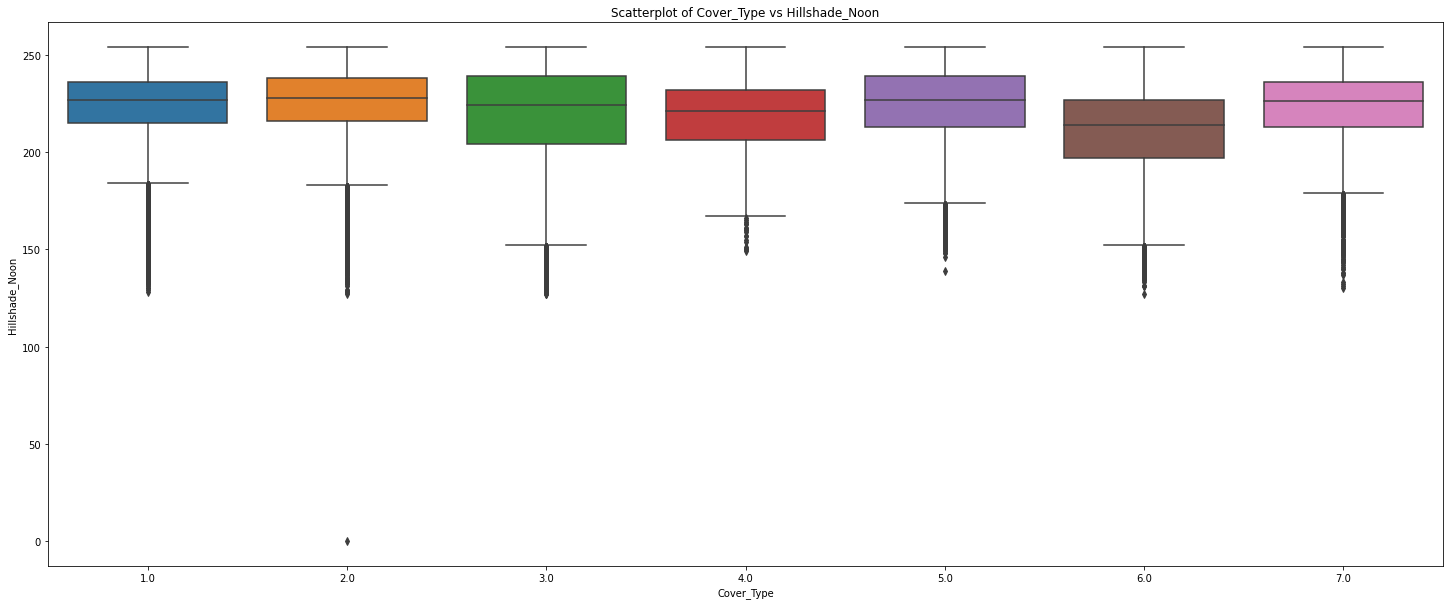

El resultado sería el siguiente: 


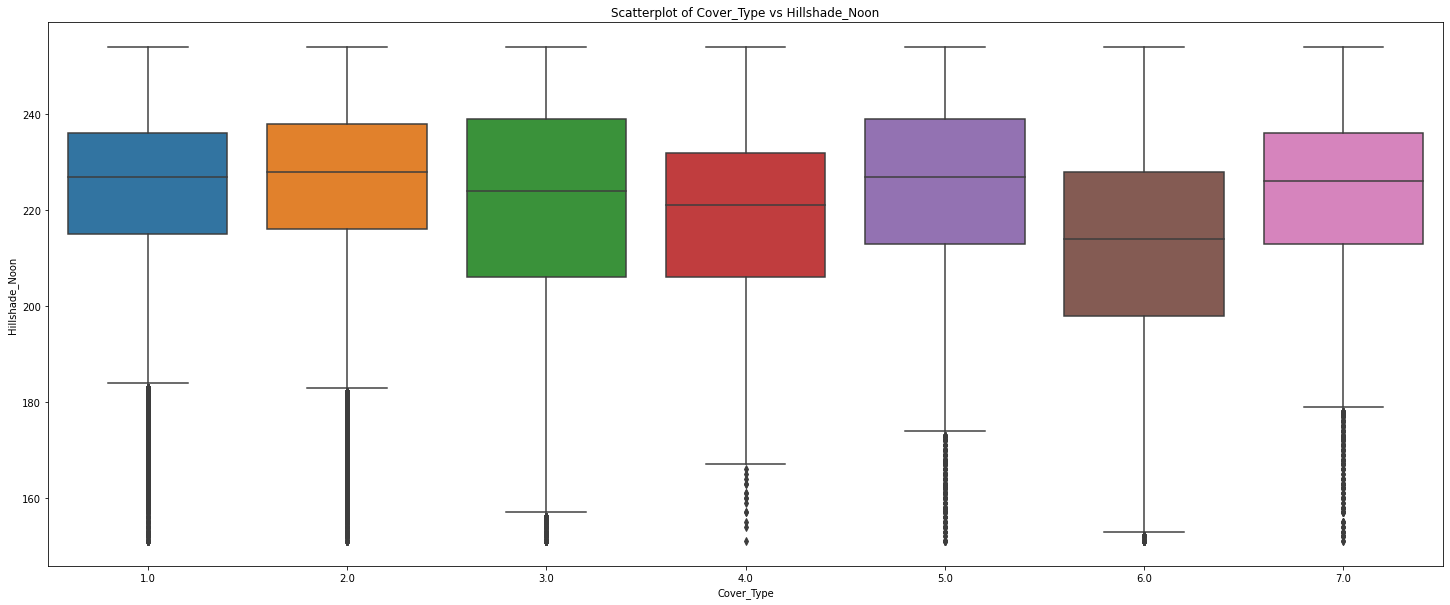

 ---------------------------------------------------- 


In [29]:
plt.figure(1, figsize=(25,10))
sns.boxplot(data=train_pd, x="Cover_Type", y='Hillshade_Noon')
plt.title(f"Scatterplot of Cover_Type vs Hillshade_Noon")
plt.show()

train_pd = train_pd.where(train_pd.Hillshade_Noon > 150)
   
print("El resultado sería el siguiente: ")
plt.figure(1, figsize=(25,10))
sns.boxplot(data=train_pd, x="Cover_Type", y="Hillshade_Noon")
plt.title(f"Scatterplot of Cover_Type vs Hillshade_Noon")
plt.show()
   
print(" ---------------------------------------------------- ")

Vamos a observar los datos de la columna Horizontal_Distance_To_Fire_Points respecto nuestro target 'Cover_Type'". Observando el gráfico haremos un filtro por abajo de 5000.
   


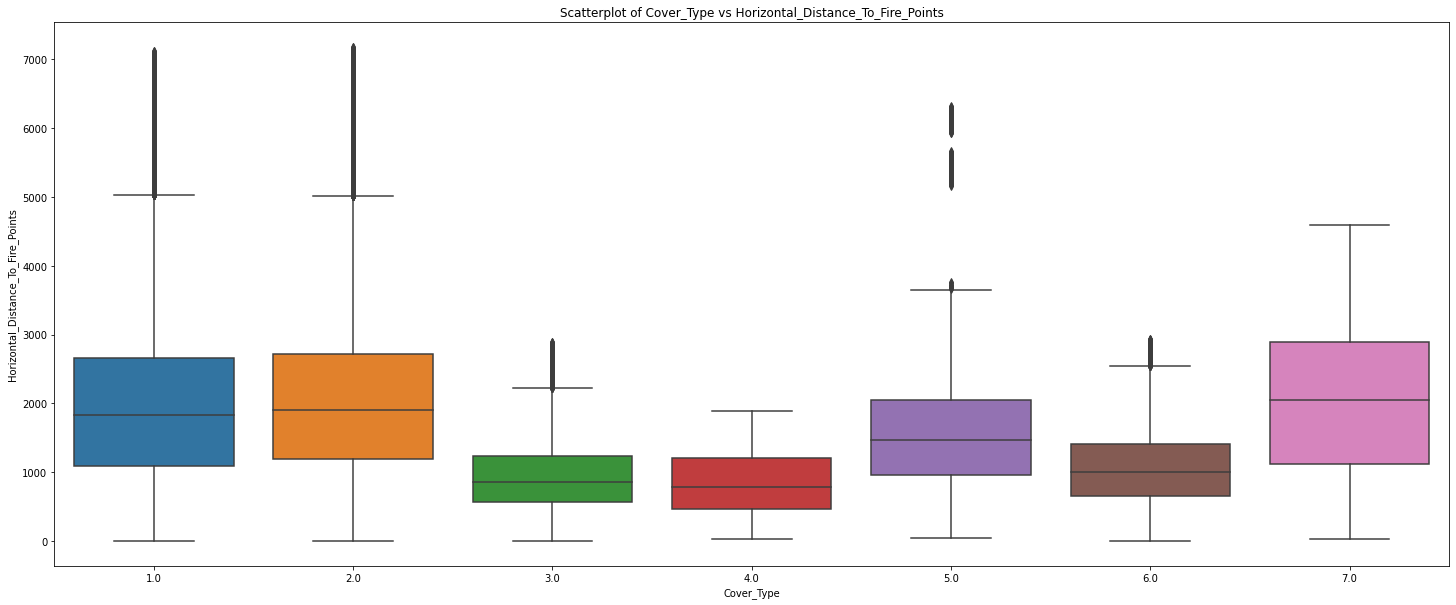

El resultado sería el siguiente: 


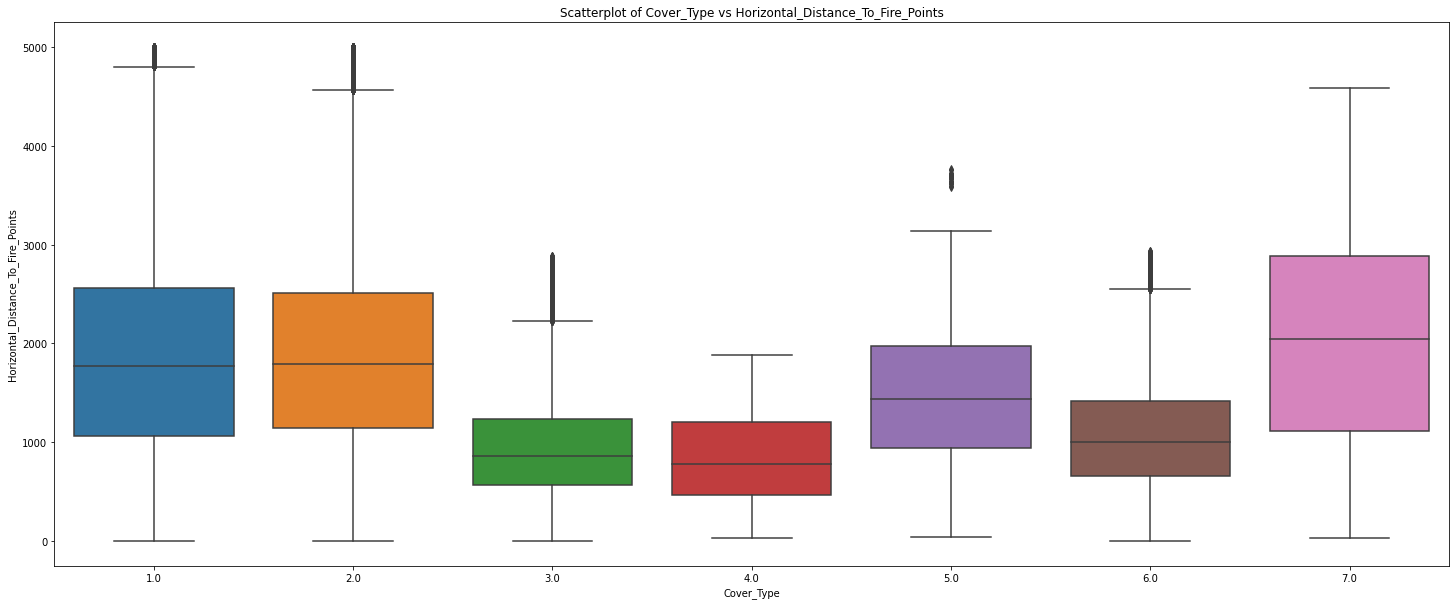

 ---------------------------------------------------- 


In [30]:
plt.figure(1, figsize=(25,10))
sns.boxplot(data=train_pd, x="Cover_Type", y='Horizontal_Distance_To_Fire_Points')
plt.title(f"Scatterplot of Cover_Type vs Horizontal_Distance_To_Fire_Points")
plt.show()

train_pd = train_pd.where(train_pd.Horizontal_Distance_To_Fire_Points<5000)
   
print("El resultado sería el siguiente: ")
plt.figure(1, figsize=(25,10))
sns.boxplot(data=train_pd, x="Cover_Type", y="Horizontal_Distance_To_Fire_Points")
plt.title(f"Scatterplot of Cover_Type vs Horizontal_Distance_To_Fire_Points")
plt.show()
   
print(" ---------------------------------------------------- ")

En los siguientes plots podremos observar que no hay outliers y es por eso que no se ha realizado ningun filtro en sus correspondientes atributos.

Vamos a observar los datos de la columna Aspect respecto nuestro target 'Cover_Type'


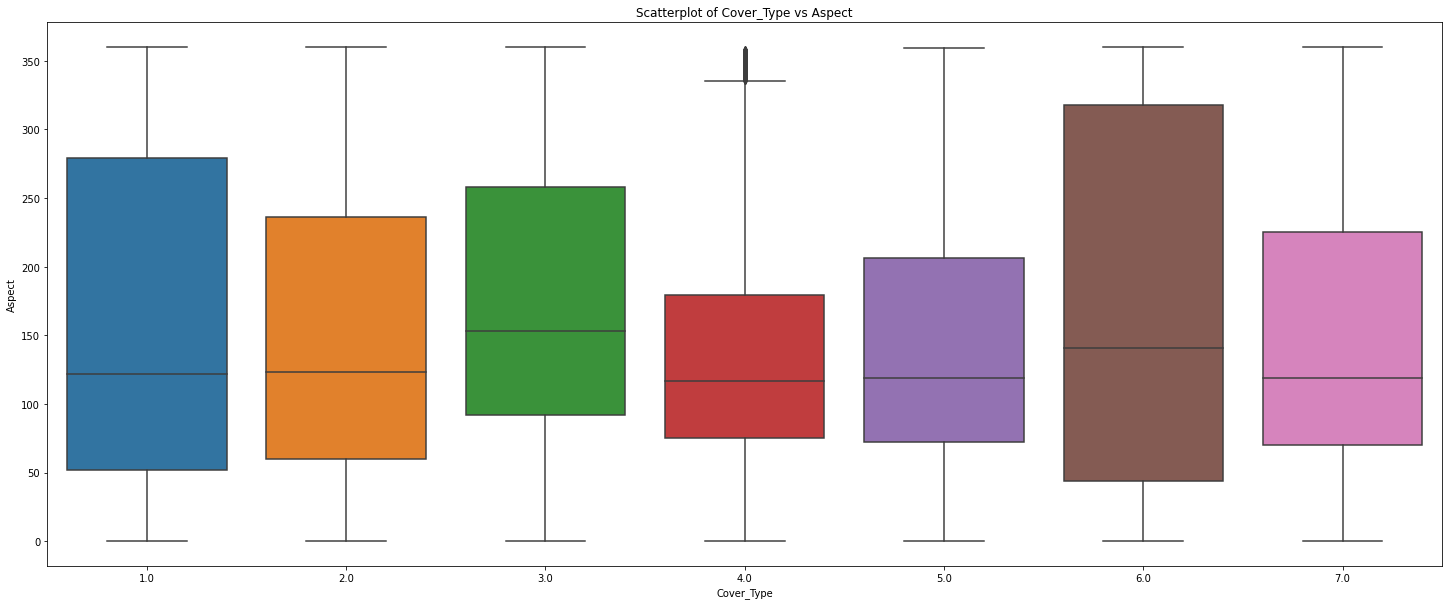

 ---------------------------------------------------- 
Vamos a observar los datos de la columna Horizontal_Distance_To_Roadways respecto nuestro target 'Cover_Type'


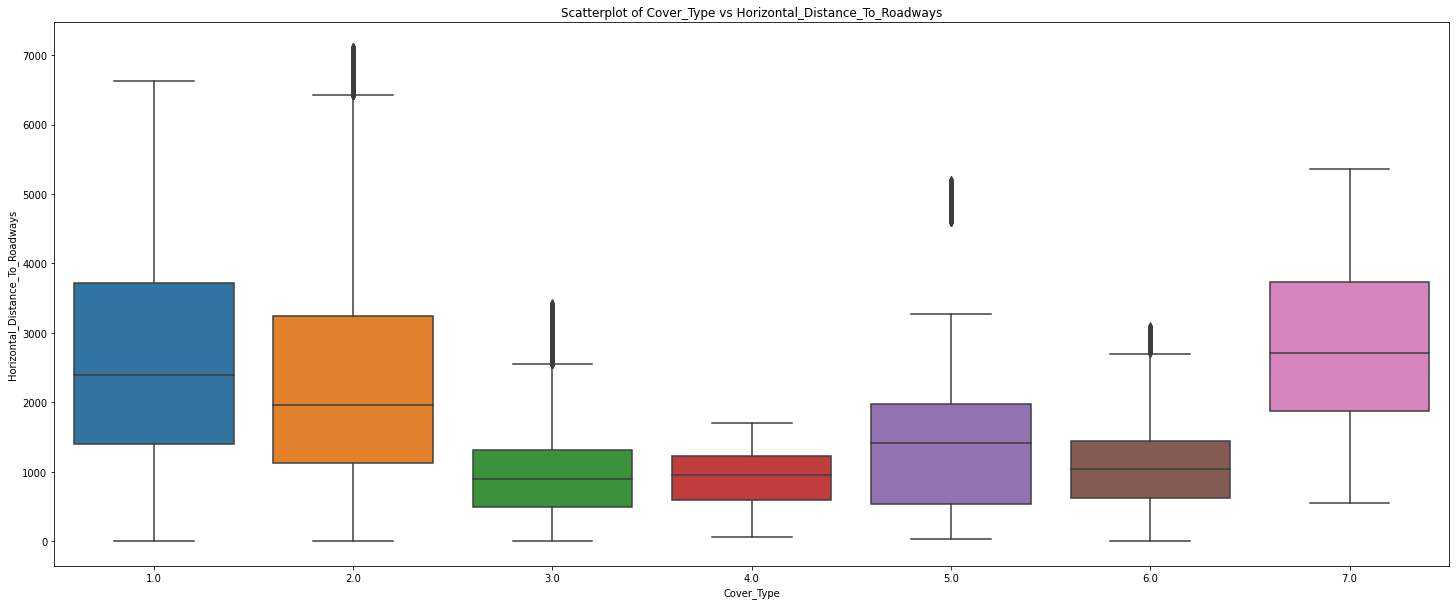

 ---------------------------------------------------- 
Vamos a observar los datos de la columna Hillshade_3pm respecto nuestro target 'Cover_Type'


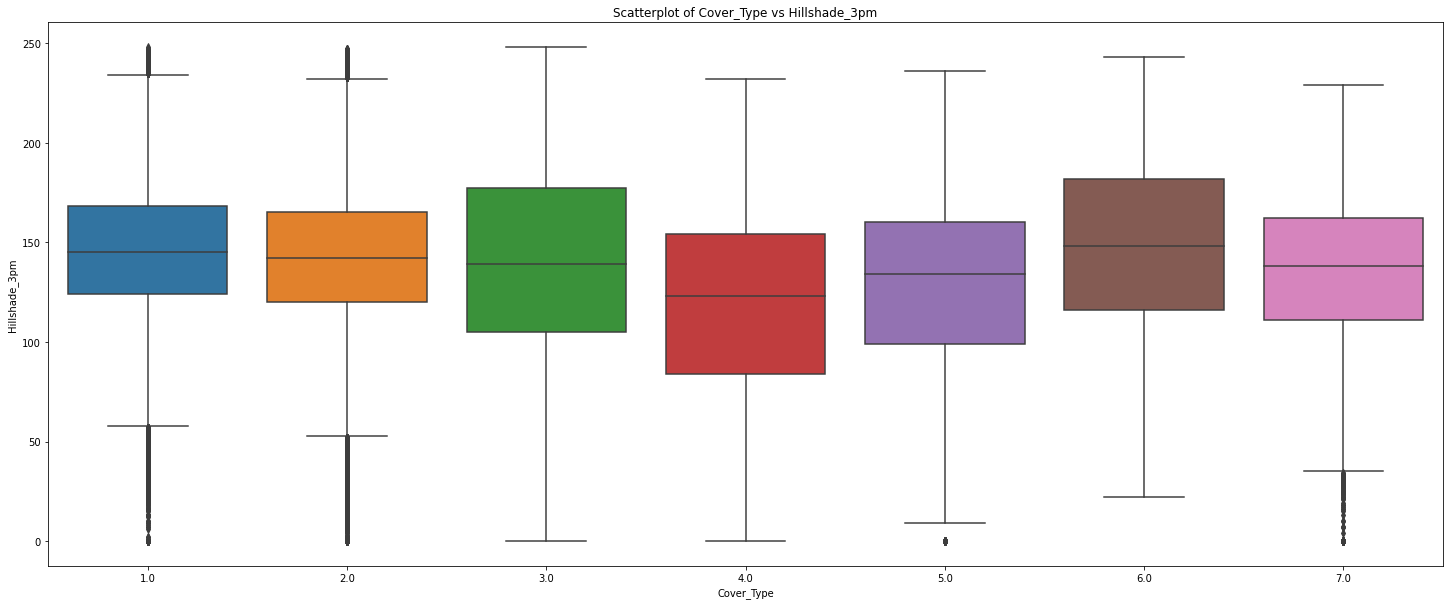

In [31]:
print(f"Vamos a observar los datos de la columna Aspect respecto nuestro target 'Cover_Type'")
   
plt.figure(1, figsize=(25,10))
sns.boxplot(data=train_pd, x="Cover_Type", y='Aspect')
plt.title(f"Scatterplot of Cover_Type vs Aspect")
plt.show()


print(" ---------------------------------------------------- ")

print(f"Vamos a observar los datos de la columna Horizontal_Distance_To_Roadways respecto nuestro target 'Cover_Type'")
   
plt.figure(1, figsize=(25,10))
sns.boxplot(data=train_pd, x="Cover_Type", y='Horizontal_Distance_To_Roadways')
plt.title(f"Scatterplot of Cover_Type vs Horizontal_Distance_To_Roadways")
plt.show()


print(" ---------------------------------------------------- ")

print(f"Vamos a observar los datos de la columna Hillshade_3pm respecto nuestro target 'Cover_Type'")
   
plt.figure(1, figsize=(25,10))
sns.boxplot(data=train_pd, x="Cover_Type", y='Hillshade_3pm')
plt.title(f"Scatterplot of Cover_Type vs Hillshade_3pm")
plt.show()
   

### Feature Engineering

La división del train i del test ya se ha realizado en la primera sección del lab, junto con el filtrado del train en la segunda sección. Así que partimos de esta base. Vamos a seguir algunas de las recomendaciones citadas en el enunciado de la practica.

Una característica potencial del dominio del conocimiento podría ser "Ratio_Distance_To_Hidrology", calculada como "Vertical_Distance_To_Hydrology"/"Horizontal_Distance_To_Hydrology"

#### Ratio Distance To Hidrology

In [9]:
train = train.withColumn("Ratio_Distance_To_Hidrology", train.Vertical_Distance_To_Hydrology / train.Horizontal_Distance_To_Hydrology )
train.select("Ratio_Distance_To_Hidrology").describe().show()

+-------+---------------------------+
|summary|Ratio_Distance_To_Hidrology|
+-------+---------------------------+
|  count|                     497924|
|   mean|         0.1700043655886752|
| stddev|        0.16133473921573718|
|    min|         -5.133333333333334|
|    max|          5.214285714285714|
+-------+---------------------------+



La variable target "Cover_Type" se convierte en un valor *Double* para trabajar con PySpark MLib. 

In [10]:
train = train.withColumn("Cover_Type", col("Cover_Type").cast(DoubleType()))
train.printSchema()

root
 |-- Elevation: integer (nullable = true)
 |-- Aspect: integer (nullable = true)
 |-- Slope: integer (nullable = true)
 |-- Horizontal_Distance_To_Hydrology: integer (nullable = true)
 |-- Vertical_Distance_To_Hydrology: integer (nullable = true)
 |-- Horizontal_Distance_To_Roadways: integer (nullable = true)
 |-- Hillshade_9am: integer (nullable = true)
 |-- Hillshade_Noon: integer (nullable = true)
 |-- Hillshade_3pm: integer (nullable = true)
 |-- Horizontal_Distance_To_Fire_Points: integer (nullable = true)
 |-- Wilderness_Area1: integer (nullable = true)
 |-- Wilderness_Area2: integer (nullable = true)
 |-- Wilderness_Area3: integer (nullable = true)
 |-- Wilderness_Area4: integer (nullable = true)
 |-- Soil_Type1: integer (nullable = true)
 |-- Soil_Type2: integer (nullable = true)
 |-- Soil_Type3: integer (nullable = true)
 |-- Soil_Type4: integer (nullable = true)
 |-- Soil_Type5: integer (nullable = true)
 |-- Soil_Type6: integer (nullable = true)
 |-- Soil_Type7: integer

A partir de la descripción original de los datos, el número de tipo de "Soil" se basa en las Unidades ecológicas de tipo de suelo (ELU) del USFS. El código ELU contiene más información sobre los suelos, incluida la zona climática y la zona geológica. Además, cada código ELU viene con una breve descripción de la que podemos extraer más información sobre la cobertura de la superficie (por rocas/cantos rodados) y el tamaño de la roca.

#### ELU CODE

In [11]:
# Mapping soil type to ELU code
ELU_CODE = {
    1:2702,2:2703,3:2704,4:2705,5:2706,6:2717,7:3501,8:3502,9:4201,
    10:4703,11:4704,12:4744,13:4758,14:5101,15:5151,16:6101,17:6102,
    18:6731,19:7101,20:7102,21:7103,22:7201,23:7202,24:7700,25:7701,
    26:7702,27:7709,28:7710,29:7745,30:7746,31:7755,32:7756,33:7757,
    34:7790,35:8703,36:8707,37:8708,38:8771,39:8772,40:8776
}

#### Soil Type Ordinal Encoding

El tipo de "Soil" es una sola variable que ha sido codificada en one-hot  para comportarse bien con una red neuronal. En general, los modelos basados en árboles funcionan mejor sin una codificación one-hot explícita, por lo que aplicaremos ingeniería inversa al tipo de de esta variable "Soil". Eliminaremos las columnas de tipo de suelo originales, lo que tiene el efecto adicional de reducir significativamente el número total de características.

In [12]:
# Encode soil type ordinally
def categorical_encoding(input_df):
    data = input_df.copy()
    data['Soil_Type'] = 0
    for i in range(1,41):
        data['Soil_Type'] += i*data[f'Soil_Type{i}']
    return data

In [13]:
# Encode soil type
train_pd = categorical_encoding(train_pd)
test_pd = categorical_encoding(test_pd)

# Original soil features
soil_features = [f'Soil_Type{i}' for i in range(1,41)]
train_pd["Soil_Type"].head(10)

0    2
1    5
2    5
3    5
4    2
5    1
6    1
7    3
8    1
9    5
Name: Soil_Type, dtype: int64

#### Climatic Zone

Creamos una característica basada en la zona climática del "Soil". Esto se puede determinar por el primer dígito del código ELU. Tenemos que tener en cuenta que la zona climatica tiene un orden:

 - lower montane dry
 - lower montane
 - montane dry
 - montane
 - montane dry and montane
 - montane and subalpine
 - subalpine
 - alpine

In [14]:
def climatic_zone(input_df):
    df = input_df.copy()
    df['Climatic_Zone'] = input_df['Soil_Type'].apply(
        lambda x: int(str(ELU_CODE[x])[0])
    )
    return df

In [15]:
# Climatic Zone
train_pd = climatic_zone(train_pd)
test_pd = climatic_zone(test_pd)
train_pd["Climatic_Zone"].head(15)

0     2
1     2
2     2
3     2
4     2
5     2
6     2
7     2
8     2
9     2
10    2
11    2
12    2
13    2
14    2
Name: Climatic_Zone, dtype: int64

#### Geologic Zone

Esta es otra característica que proviene directamente del código ELU. La zona geológica está determinada por el segundo dígito del código ELU. A diferencia de la zona climática, la zona geológica no tiene un orden:

- aluvión
- glacial
- esquisto
- arenisca
- sedimentario mixto
- no especificado en la encuesta USFS ELU
- ígneas y metamórficas
- volcánico

In [16]:
def geologic_zone(input_df):
    df = input_df.copy()
    df['Geologic_Zone'] = input_df['Soil_Type'].apply(
        lambda x: int(str(ELU_CODE[x])[1])
    )
    return df

In [17]:
# Geologic Zone
train_pd = geologic_zone(train_pd)
test_pd = geologic_zone(test_pd)
train_pd["Geologic_Zone"].head(15)

0     7
1     7
2     7
3     7
4     7
5     7
6     7
7     7
8     7
9     7
10    7
11    7
12    7
13    7
14    7
Name: Geologic_Zone, dtype: int64

#### Surface Cover

Esta característica también se basa en el código ELU y la descripción de datos original para cada tipo de "Soil". De acuerdo con la referencia del USDA sobre perfiles de suelo:

- (Stony/Bouldery)
- (Very Stony/Very Bouldery)
- (Extremely Stony/Extremely Bouldery)
- (Rubbly)
- (Very Rubbly)

Si no se da una descripción de la familía, le pondre un 0.

In [18]:
def surface_cover(input_df):
    no_desc = [7,8,14,15,16,17,19,20,21,23,35]
    stony = [6,12]
    very_stony = [2,9,18,26]
    extremely_stony = [1,22,24,25,27,28,29,30,31,32,33,34,36,37,38,39,40]
    rubbly = [3,4,5,10,11,13]

    # Create dictionary
    surface_cover = {i:0 for i in no_desc}
    surface_cover.update({i:1 for i in stony})
    surface_cover.update({i:2 for i in very_stony})
    surface_cover.update({i:3 for i in extremely_stony})
    surface_cover.update({i:4 for i in rubbly})
    
    # Create Feature
    df = input_df.copy()
    df['Surface_Cover'] = input_df['Soil_Type'].apply(
        lambda x: surface_cover[x]
    )
    return df

In [19]:
train_pd = surface_cover(train_pd)
test_pd = surface_cover(test_pd)
train_pd["Surface_Cover"].head(15)

0     2
1     4
2     4
3     4
4     2
5     3
6     3
7     4
8     3
9     4
10    3
11    2
12    4
13    2
14    4
Name: Surface_Cover, dtype: int64

#### Rock Size

La última característica del tipo de "Soil" que consideramos es el tamaño de la roca. Esto también se determina a partir del código ELU, la descripción de los datos originales y la referencia del perfil del suelo del USFS:

- Stones
- Boulders
- Rubble (escombros)

Si la descripción del tipo de suelo no menciona el tamaño de la roca, le damos un valor predeterminado de 0.

In [20]:
def rock_size(input_df):
    no_desc = [7,8,14,15,16,17,19,20,21,23,35]
    stones = [1,2,6,9,12,18,24,25,26,27,28,29,30,31,32,33,34,36,37,38,39,40]
    boulders = [22]
    rubble = [3,4,5,10,11,13]

    # Create dictionary
    rock_size = {i:0 for i in no_desc}
    rock_size.update({i:1 for i in stones})
    rock_size.update({i:2 for i in boulders})
    rock_size.update({i:3 for i in rubble})
    
    df = input_df.copy()
    df['Rock_Size'] = input_df['Soil_Type'].apply(
        lambda x: rock_size[x]
    )
    return df

In [21]:
# Surface Cover
train_pd = rock_size(train_pd)
test_pd = rock_size(test_pd)
train_pd["Rock_Size"].head(15)

0     1
1     3
2     3
3     3
4     1
5     1
6     1
7     3
8     1
9     3
10    1
11    1
12    3
13    1
14    3
Name: Rock_Size, dtype: int64

#### Dimension Reduction

Ahora que hemos creado columnas más interesantes que Soil_Type{i}, vamos a eliminar estas (dimension reduction).

In [22]:
train_pd.drop(columns = soil_features, inplace = True)
test_pd.drop(columns = soil_features, inplace = True)

Vamos a ver como han quedado las *features* de nuestro conjunto de entrenamiento.

In [23]:
train_pd.head(5)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Cover_Type,Soil_Type,Climatic_Zone,Geologic_Zone,Surface_Cover,Rock_Size
0,1863,37,17,120,18,90,217,202,115,769,0,0,0,1,6,2,2,7,2,1
1,1874,18,14,0,0,90,208,209,135,793,0,0,0,1,6,5,2,7,4,3
2,1879,28,19,30,12,95,209,196,117,778,0,0,0,1,6,5,2,7,4,3
3,1896,337,12,30,6,175,195,224,168,732,0,0,0,1,6,5,2,7,4,3
4,1898,34,23,175,56,134,210,184,99,765,0,0,0,1,6,2,2,7,2,1


Una vez acabado el análisi, volvemos a convertir el PandasDataframe a SparkDataframe para el siguiente paso.

In [24]:
train = spark.createDataFrame(train_pd)
test = spark.createDataFrame(test_pd)

### Model training

Para poder realizar el siguiente apartado deberemos importar las siguientes librerias de pyspark:

In [25]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import DoubleType
from sklearn.metrics import confusion_matrix

Antes de ejecutar el DecisionTreeClassifier, vamos a preparar los datos, para usarlos con un clasificador en MLlibl.

El DataFrame de entrada contiene muchas columnas, cada una con una característica que podría usarse para predecir la columna de destino. MLlib requiere que todas las entradas se recopilen en una columna, cuyo valor es un vector. Esta clase es una abstracción de vectores en el sentido del álgebra lineal y solo contiene números. Para la mayoría de los intentos y propósitos, funcionan como una matriz simple de valores dobles (números de coma flotante). Por supuesto, algunas de las características de entrada son conceptualmente categóricas, incluso si todas están representadas con números en la entrada.

Afortunadamente, la clase VectorAssembler puede hacer este trabajo:

In [33]:
train_vector_assembler = VectorAssembler(inputCols = train.drop("Cover_Type").columns, outputCol = 'featureVector').setHandleInvalid("keep")
test_vector_assembler = VectorAssembler(inputCols = test.columns, outputCol = 'featureVector').setHandleInvalid("keep")

train_vector = train_vector_assembler.transform(train)
test_vector = test_vector_assembler.transform(test)

Ahora, podemos ejecturar el modelo.

In [34]:
classifier = DecisionTreeClassifier(seed=seed, labelCol="Cover_Type", featuresCol="featureVector", predictionCol="prediction")

trained_model = classifier.fit(train_vector)

pred = trained_model.transform(test_vector)


Los árboles de decisión pueden evaluar la importancia de las características de entrada como parte de su proceso de construcción. Es decir, pueden estimar cuánto contribuye cada característica de entrada a hacer predicciones correctas. Esta información es de fácil acceso desde el modelo. Cuanto mayor sea el valor, mejor.

In [35]:
pd.DataFrame(trained_model.featureImportances.toArray(), index=train.drop("Cover_Type").columns, columns=['importance']).sort_values(by="importance", ascending=False).head(13)

,importance
Elevation,0.723741
Soil_Type,0.076827
Geologic_Zone,0.044985
Climatic_Zone,0.044028
Wilderness_Area3,0.041269
Wilderness_Area1,0.031490
Hillshade_Noon,0.018813
Horizontal_Distance_To_Hydrology,0.011755
Horizontal_Distance_To_Fire_Points,0.006791
Horizontal_Distance_To_Roadways,0.000300


Vemos que las features con más importancia son aquellas que hemos creado nosotros en el featureEngineering, por lo tanto, podemos decir que son buenas columnas, o almenos, mejor que el SoilType{i} de base.

Vamos a visualizar algunas de las columnas computadas por el modelo. El resultado también contendra la columna "probabilidad" que proporciona la estimación del modelo de la probabilidad de que cada posible resultado sea correcto. Esto muestra que en estos casos, es bastante seguro que la respuesta es 3 en varios casos y bastante seguro que la respuesta no es 1.

In [36]:
pred.select("Cover_Type", "prediction", "probability").show(10, truncate = False)

+----------+----------+------------------------------------------------------------------------------------------------------------------+
|Cover_Type|prediction|probability                                                                                                       |
+----------+----------+------------------------------------------------------------------------------------------------------------------+
|6         |3.0       |[0.0,0.0,0.05898918783002263,0.6901181795323108,0.06688458637163691,3.0173497611264775E-4,0.18370631128991702,0.0]|
|6         |3.0       |[0.0,0.0,0.05898918783002263,0.6901181795323108,0.06688458637163691,3.0173497611264775E-4,0.18370631128991702,0.0]|
|6         |3.0       |[0.0,0.0,0.05898918783002263,0.6901181795323108,0.06688458637163691,3.0173497611264775E-4,0.18370631128991702,0.0]|
|3         |3.0       |[0.0,0.0,0.05898918783002263,0.6901181795323108,0.06688458637163691,3.0173497611264775E-4,0.18370631128991702,0.0]|
|3         |3.0       |[0.0

Este vector de "probability" tiene 8 valores, aunque el total de *otputs* sea de 7 columnas. Esto es debido a que en este también existe un valor en el indice 0, en el que siempre se muestra la probabilidad de 0.0. Este valor peude ser ignorado.

### Evaluation

Para evaluar el modelo, tenemos diferentes métricas, vamos a utilizar el accuracy.

In [37]:
evaluator = MulticlassClassificationEvaluator(labelCol="Cover_Type", predictionCol="prediction")

accur = evaluator.setMetricName("accuracy").evaluate(pred)
f1 = evaluator.setMetricName("f1").evaluate(pred)

In [38]:
print("Accuracy:", accur)
print(f"F1:", f1)

Accuracy: 0.6733778426872522
F1: 0.6446491722949704


Mediante la librería *sklearn* también podemos ver la *confussion matrix*.

In [32]:
y_pred=pred.select("Cover_Type").collect()
y_orig=pred.select("Cover_Type").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[190123      0      0      0      0      0      0]
 [     0 254741      0      0      0      0      0]
 [     0      0  31787      0      0      0      0]
 [     0      0      0   1978      0      0      0]
 [     0      0      0      0   8042      0      0]
 [     0      0      0      0      0  15086      0]
 [     0      0      0      0      0      0  17958]]


### Random Forest

In [8]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# init random forest object
rf = RandomForestClassifier(
    featuresCol='featureVector', 
    labelCol='Cover_Type',
    predictionCol="prediction",
)

rfc = rf.fit(train_vector)

pred = rfc.transform(test_vector)